In [1]:
from SD_IB_IRP_PPenv import steroid_IRP
from Policies import policies
from IPython.display import Image
import matplotlib.pyplot as plt
import scipy.stats as st
import imageio

# Auxiliary function to visualize episode
def print_state(env):
    print(f'################################### STEP {env.t} ###################################')
    print('INVENTORY')
    max_age = max(list(env.O_k.values()))
    string = 'M \ O \t'
    for o in range(1, max_age + 1):
        string += f' {o} \t \t'
    print(string)
    for k in env.Products:
        string = f'S{k} \t \t '
        for o in env.Ages[k]:
            string += f'{env.state[k,o]} \t'
        print(string)
    
    print('\n')
    print('DEMAND')
    string1 = 'K'
    string2 = 'd'
    for k in env.Products:
        string1 += f'\t {k}\t'
        string2 += f'\t {env.W_t["d"][k]}'
    print(string1)
    print(string2)

    print('\n')
    print('AVAILABLE QUANTITIES')
    string = 'M \ K \t'
    for k in env.Products:
        string += f'{k} \t \t'
    print(string)
    for i in env.Suppliers:
        new_string = f'{i} \t \t'
        for k in env.Products:
            if env.W_t['q'][i,k] == 0:
                new_string += f'{env.W_t["q"][i,k]} \t \t'
            else:
                new_string += f'{env.W_t["q"][i,k]} \t'
        print(new_string)


def print_extras(env, action, _):
    print('\n')
    print('PURCHASE')
    purchase = action[1]
    string = 'M \ K \t'
    for k in env.Products:
        string += f'{k} \t \t'
    print(string)
    for i in env.Suppliers:
        new_string = f'{i} \t \t'
        for k in env.Products:
            if purchase[i,k] == 0:
                new_string += f'{float(purchase[i,k])} \t'
            else:
                new_string += f'{round(purchase[i,k],2)} \t'
        print(new_string)
    
    print('\n')
    print('Demand compliance')
    demand_compliance = action[2]
    max_age = max(list(env.O_k.values()))
    string = 'K \ O \t'
    for o in range(max_age + 1):
        string += f' {o} \t \t'
    print(string)
    for k in env.Products:
        string = f'K{k} \t \t '
        for o in range(env.O_k[k] + 1):
            string += f'{round(demand_compliance[k,o],2)} \t'
        print(string)

    print('\n')
    print('BACKORDERS')
    string1 = 'K'
    string2 = 'bo'
    for k in env.Products:
        if k in _['backorders'].keys():
            string1 += f'\t {k}\t'
            string2 += f'\t {_["backorders"][k]}'
    print(string1)
    print(string2)

    print('\n \n \n \n \n')

# Policy Evaluation

This Notebook has a complete Policy Evaluation function for the Stochastic-Dynamic Inventory-Routing-Problem with Perishable Products. First, the main parameters of the problem and the environment must be set. All the main customizable parameters are below.

In [2]:
#################################   Environment's parameters   #################################
# Random seed
rd_seed = 20

# SD-IB-IRP-PP model's parameters
backorderss = 'backorders'
stochastic_parameters = ['q','d']

# Feature's parameters
look_ahead = ['q','d']
historical_data = ['*']

# Action's parameters
validate_action = False
warnings = False

# Other parameters
num_episodes = 1
env_config = { 'M': 5, 'K': 5, 'T': 6,  'F': 4, 
               'S': 10,  'LA_horizon': 3, 'back_o_cost': 1e5}

q_params = {'distribution': 'c_uniform', 'min': 6, 'max': 20}
d_params = {'distribution': 'log-normal', 'mean': 2, 'stdev': 0.5}

p_params = {'distribution': 'd_uniform', 'min': 1, 'max': 500}
h_params = {'distribution': 'd_uniform', 'min': 1, 'max': 500}

#################################   Environment's parameters   #################################

Next, the policy evaluation is defined. This function only takes one parameter, the number of episodes that will be runned of the environment. All the policies to be evaluated must be in the 'Policies.py' file. Any policy used must be able to receive the state, the additional information in _ and the environment as a parameters. Also, the policy function must return an action in the format defined in the Toying.ipynb.

In [3]:
'''

'''
def Policy_evaluation(num_episodes = 1000):
    
    # Episode's and performance storage
    rewards = {};   states = {};   real_actions = {};   backorders = {};   la_decisions = {}
    realized_dem = {};   q_sample = {};   tws = {}; perished = {}; realized_q = {}

    # Generating environment and policies generator
    env = steroid_IRP( look_ahead = look_ahead, 
                       historical_data = historical_data, 
                       backorders = backorderss,
                       stochastic_parameters = stochastic_parameters, 
                       env_config = env_config)

    policy = policies()

    for episode in range(1):

        state, _ = env.reset( return_state = True, rd_seed = rd_seed, q_params = q_params, 
                              p_params = p_params, d_params = d_params, h_params = h_params)

        
        done = False
        while not done:
            #print_state(env)
            # Environment transition
            states[episode,env.t] = state
            q_sample[episode,env.t] = [_["sample_paths"]["q"][0,s] for s in env.Samples]
            action, la_dec = policy.stochastic_rolling_horizon(state, _, env)
            if done:    tws[episode,env.t] = 1
            else:    tws[episode,env.t] = _["sample_path_window_size"]
            state, reward, done, real_action, _,  = env.step(action, validate_action = validate_action, warnings = warnings)
            if done:    states[episode,env.t] = state

            #print_extras(env, real_action, _)

            # Data storage
            real_actions[episode,env.t-1] = real_action
            backorders[episode,env.t-1] = _["backorders"]
            perished[episode,env.t-1] = {k:_["perished"][k] if k in _["perished"] else 0 for k in env.Products}
            rewards[episode,env.t] = reward
            la_decisions[episode,env.t-1] = la_dec
            realized_dem[episode,env.t-1] = env.W_t["d"]
            realized_q[episode,env.t-1] = env.W_t["q"]
            
            
    iterables = (env.Suppliers, env.Products, env.Samples, env.M_kt, env.O_k, env.Horizon)
    costs = (env.c, env.h_t, env.p_t, env.back_o_cost)

    return rewards, states, real_actions, backorders, la_decisions, realized_dem, q_sample, tws, iterables, costs, perished, realized_q

In [4]:
rewards, states, real_actions, backorders, la_decisions, realized_dem, q_sample, tws, iterables, costs, perished, realized_q = Policy_evaluation(num_episodes = num_episodes)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-02


In [5]:
def get_historical_decisions(episode, states, real_actions, backorders, K, T, O_k, perished):
    # Initial Inventory level for product k, aged o
    ii_0 = {t:states[episode,t] for t in range(len(T)+1)}
    # Final Inventory level
    ii_f = {t:{(k,o):ii_0[t+1][k,o+1] if o<O_k[k] else perished[episode,t][k] for k in K for o in range(O_k[k]+1)} for t in T}
    # Routing Decisions
    rout = {t:real_actions[episode,t][0] for t in T}
    # Purchasing decisions
    purch = {t:real_actions[episode,t][1] for t in T}
    # Backorders
    back = {t:{k:backorders[episode,t][k] if k in backorders[episode,t] else 0 for k in K} for t in T}

    return ii_0, ii_f, rout, purch, back

def get_lookahead_decisions(episode, day, la_decisions, T, K, O_k, S, I_0):
    # Final Inventory level
    ii_f_la = {(t):la_decisions[episode,day][0][t-day] for t in T}
    # Initial Inventory level
    ii_0_la = {(t):{s:{(k,o):ii_f_la[t-1][s][k,o-1] if t>T[0] else I_0[t][k,o] for k in K for o in range(1,O_k[k]+1)} for s in S} for t in T}
    # Purchase Decisions
    purch_la = {(t):la_decisions[episode,day][1][t-day] for t in T}
    # Backorders
    back_la = {(t):la_decisions[episode,day][2][t-day] for t in T}

    return ii_0_la, ii_f_la, purch_la, back_la

def charts_max_axis_values(episode, states, real_actions, backorders, la_decisions, tws, iterables, costs, perished):
    
    M, K, S, M_kt, O_k, T = iterables

    ''' Costs '''
    c = costs[0]
    h = costs[1]
    p = costs[2]
    g = costs[3]/1e3

    ''' Realized, Historical Decisions '''
    ii_0, ii_f, rout, purch, back = get_historical_decisions(episode,states,real_actions,backorders, K, T, O_k, perished)

    ''' Lookahead Decisions '''
    ii_0_la, ii_f_la, purch_la, back_la = {}, {}, {}, {}
    for t in T:
        ii_0_la[t], ii_f_la[t], purch_la[t], back_la[t] = get_lookahead_decisions(episode, t, la_decisions, range(t,t+tws[episode,t]), K, O_k, S, ii_0)

    ''' First chart'''
    initi = [sum(ii_0[t][k,o] for k in K for o in range(1,O_k[k]+1)) for t in T]
    repl = [sum(purch[t][i,k] for i in M for k in K) for t in T]
    backo = [sum(back[t][k] for k in K) for t in T]
    # Past and today's realized decisions
    ub1 = max([initi[t]+repl[t]+backo[t] for t in T])
    initi = {(tau,t,s):sum(ii_0_la[tau][t][s][k,o] for k in K for o in range(1,O_k[k]+1)) for tau in T for t in range(tau,tau+ tws[episode,tau]) for s in S}
    repl = {(tau,t,s):sum(purch_la[tau][t][s][i,k] for k in K for i in M_kt[k,t]) for tau in T for t in range(tau,tau+ tws[episode,tau]) for s in S}
    backo = {(tau,t,s):sum(back_la[tau][t][s][k] for k in K) for tau in T for t in range(tau,tau+ tws[episode,tau]) for s in S}
    # Future lookahead decisions
    ub1 = max(ub1,*[initi[tau,t,s]+repl[tau,t,s] for tau in T for t in range(tau+1,tau+ tws[episode,tau]) for s in S])
    # Today lookahead decisions
    ub1 = max(ub1,*[initi[tau,tau,s]+repl[tau,tau,s]+backo[tau,tau,s] for tau in T for s in S])
    ub1 = (int(ub1/50)+1)*50

    ''' Second chart '''
    # Max x value
    back_li = [sum(back_la[tau][tau][s][k] for k in K) for s in S for tau in T]
    ub31 = max(back_li)
    ub31 = (int(ub31/10)+1)*10
    # Max value for y axis
    ub32 = 0
    for tau in T:
        hist_b = plt.hist([sum(back_la[tau][tau][s][k] for k in K) for s in S])[0]
        for i in hist_b:
            if i > ub32:
                ub32 = i
    plt.close()

    ''' Fourth chart'''
    purcha = [sum(p[t][i,k]*purch[t][i,k] for i in M for k in K) for t in T]
    hold = [sum(h[t][k]*ii_f[t][k,o] for k in K for o in range(O_k[k]+1)) for t in T]
    backo = [sum(g*back[t][k] for k in K) for t in T]
    routi = [sum(c[rout[t][i][j],rout[t][i][j+1]] for i in range(len(rout[t])) for j in range(len(rout[t][i])-1)) for t in T]
    # Past and today's realized decisions
    ub4 = max([purcha[t]+hold[t]+backo[t]+routi[t] for t in T])
    purch = {(tau,t,s):sum(p[t][i,k]*purch_la[tau][t][s][i,k] for k in K for i in M_kt[k,t]) for tau in T for t in range(tau,tau+ tws[episode,tau]) for s in S}
    hold = {(tau,t,s):sum(h[t][k]*ii_f_la[tau][t][s][k,o] for k in K for o in range(1,O_k[k]+1)) for tau in T for t in range(tau,tau+ tws[episode,tau]) for s in S}
    backo = {(tau,t,s):sum(g*back_la[tau][t][s][k] for k in K) for tau in T for t in range(tau,tau+ tws[episode,tau]) for s in S}
    # Today's and future lookahead decisions
    ub4 = max(ub4,*[purch[tau,t,s]+hold[tau,t,s]+backo[tau,t,s] for tau in T for t in range(tau,tau+ tws[episode,tau]) for s in S])
    ub4 = (int(ub4/1e4)+1)*1e4

    return [ub1,(ub31,ub32),ub4]


def append_routes(rout):
    sups = []
    for i in rout:
        sups += i[1:-1]
    sups = list(set(sups))

    return sups

def quantity_boxplot(ax, suppliers, q_s, K, S, colors, ind):
    boxi = ax.boxplot([sum(q_s[s][i,k] for k in K for s in S)/(len(S)) for i in suppliers],positions=[0.75+1.5*ind],widths=[0.3],vert=True,patch_artist=True,flierprops = dict(markerfacecolor=colors["box_avail"][1], markeredgecolor=colors["box_avail"][0]))
    return boxi

def price_boxplot(ax, suppliers, p, day, K, colors, ind):
    price_list = {i:[p[day][i,k] for k in K if p[day][i,k] < 1e3] for i in suppliers}
    boxi = ax.boxplot([sum(price_list[i])/len(price_list[i]) for i in suppliers],positions=[1.25+1.5*(ind)],widths=[0.3],vert=True,patch_artist=True,flierprops = dict(markerfacecolor=colors["box_prices"][1], markeredgecolor=colors["box_prices"][0]))
    return boxi

def visualize_by_day(episode, day, states, real_actions, backorders, la_decisions, realized_dem, q_sample, tws, iterables, costs, conf_level, max_vals, myopic_actions, perished, save=False):
    
    azul = (41/255,122/255,204/255)
    verde = (70/255,145/255,57/255)
    naranja = (235/255,140/255,68/255)
    morado = (99/255,45/255,235/255)
    rosado = (199/255,93/255,169/255)

    colors = {"hold":[naranja,"palegreen"],
                   "back":[azul,"cyan"],
                   "purch":[verde,"palegreen"],
                   "rout":[rosado,"violet"],
                   "dem":[morado,"mediumpurple"],
                   "box_avail":[(91/255,179/255,77/255),(213/255,230/255,123/255)],
                   "box_prices":[(181/255,21/255,0/255),(223/255,159/255,156/255)]}

    M, K, S, M_kt, O_k, T = iterables

    ''' Realized, Historical Decisions '''
    hist_T = range(day+1)
    ii_0, ii_f, rout, purch, back = get_historical_decisions(episode,states,real_actions,backorders, K, hist_T, O_k, perished)

    ''' Realized demand '''
    d = {t:realized_dem[episode,t] for t in hist_T}

    ''' Look-ahead Decisions '''
    la_T = range(day,day+tws[episode,day])
    ii_0_la, ii_f_la, purch_la, back_la = get_lookahead_decisions(episode, day, la_decisions, la_T, K, O_k, S, ii_0)

    ''' Quantity sample paths '''
    q_s = {s:q_sample[episode,day][s] for s in S}

    ''' Myopic algorithm decisions '''
    #rout_myopic = {t:myopic_actions[episode,t][0] for t in T}

    ''' Costs '''
    c = costs[0]
    h = costs[1]
    p = costs[2]
    g = costs[3]/1e3

    spec = {"height_ratios":[1, 1, 1, 1],"hspace":0.25,"bottom":0.1,"top":0.9}
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4,ncols=1,figsize=(13,20),gridspec_kw=spec)

    ''' First Chart: Quantities '''
    # Max value for the axis
    ub1 = max_vals[0]

    # Realized decisions
    for t in hist_T:
        initi = sum(ii_0[t][k,o] for k in K for o in range(1,O_k[k]+1))
        repl = sum(purch[t][i,k] for i in M for k in K)
        backo = sum(back[t][k] for k in K)
        if t == day:
            x_adj = 0.2
            wid = 0.4
        else:
            x_adj = 0
            wid = 0.8
        ax1.bar(x=t-x_adj, height=initi, color=colors["hold"][0],width=wid)
        ax1.bar(x=t-x_adj, height=repl, bottom=initi, color=colors["purch"][0],width=wid)
        ax1.bar(x=t-x_adj, height=backo, bottom=initi+repl, color=colors["back"][0], width=wid)

    # Look-ahead decisions
    for t in la_T:
        initi = [sum(ii_0_la[t][s][k,o] for k in K for o in range(1,O_k[k]+1)) for s in S]
        repl = [sum(purch_la[t][s][i,k] for k in K for i in M_kt[k,t]) for s in S]
        backo = [sum(back_la[t][s][k] for k in K) for s in S]
        if t == day:
            tq = [initi[s]+repl[s]+backo[s] for s in S]
            cin = st.t.interval(confidence=conf_level, df=len(tq)-1, loc=sum(tq)/len(tq), scale=st.sem(tq)) 
            ax1.axvline(x=t+0.2,ymin=cin[0]/ub1,ymax=cin[1]/ub1,color="black",marker="_",mew=1.5,ms=8)
            bot_back = (sum(initi)+sum(repl))/len(S)
            x_adj = 0.2
        else:
            tq = [initi[s]+repl[s] for s in S]
            cin = st.t.interval(confidence=conf_level, df=len(tq)-1, loc=sum(tq)/len(tq), scale=st.sem(tq)) 
            ax1.axvline(x=t-0.2,ymin=cin[0]/ub1,ymax=cin[1]/ub1,color="black",marker="_",mew=1.5,ms=8)
            cin = st.t.interval(confidence=conf_level, df=len(backo)-1, loc=sum(backo)/len(backo), scale=st.sem(backo))
            ax1.axvline(x=t+0.2,ymin=cin[0]/ub1,ymax=cin[1]/ub1,color="black",marker="_",mew=1.5,ms=8)
            bot_back = 0
            x_adj = -0.2
        ax1.bar(x=t+x_adj, height=sum(initi)/len(S), color=colors["hold"][0], width=0.4, alpha=0.5)
        ax1.bar(x=t+x_adj, height=sum(repl)/len(S), bottom=sum(initi)/len(S), color=colors["purch"][0], width=0.4, alpha = 0.5)
        ax1.bar(x=t+0.2, height=sum(backo)/len(S), bottom=bot_back, color=colors["back"][0], width=0.4, alpha=0.5)
    
    # Historical realized demand
    ax1.plot([t for t in hist_T],[sum(d[t][k] for k in K) for t in hist_T],linestyle="-",marker="*",markersize=12,color="black")
    
    # Chart config
    ax1.set_xlim(-0.5,len(T)-0.5)
    ax1.set_ylim(0,ub1)
    ax1.set_xlabel("Time period")
    ax1.set_ylabel("Quantity")
    ax1.bar(x=day,height=0,color=colors["back"][0],label="Backorders")
    ax1.bar(x=day,height=0,color=colors["purch"][0],label="Replenishment")
    ax1.bar(x=day,height=0,color=colors["hold"][0],label="Initial Inv. Level")
    ax1.plot(day+len(T),0,color="black",linestyle="-",marker="*",markersize=9,label="Demand")
    ax1.legend(loc="upper right",ncol=2)

    ''' Second chart: backorders histogram '''
    # Max values for axis
    ub31, ub32 = max_vals[1]
    
    # Backorders histogram
    ax2.hist([sum(back_la[day][s][k] for k in K) for s in S], color=colors["back"][1], edgecolor=colors["back"][0], alpha = 0.5, density = False, label="Backorders")
    
    # Chart config
    ticks = [i for i in range(0,int(ub31+1),int(ub31/10))]
    ax2.set_xticks(ticks=ticks)
    ax2.set_xlabel("Units")
    ax2.set_xlim(-5,ub31+5)
    ax2.set_ylim(0,ub32+1)
    ax2.legend(loc="upper center",ncol=2)

    ''' Third chart: boxplots '''
    
    # Availability boxplots
    suppliers_visited = {"all":M, "st":append_routes(rout[day])}#, "myo":append_routes(rout_myopic[day])}

    box1 = quantity_boxplot(ax3,suppliers_visited["all"],q_s,K,S,colors,0)
    box2 = quantity_boxplot(ax3,suppliers_visited["st"],q_s,K,S,colors,1)
    #box3 = quantity_boxplot(ax3,suppliers_visited["myo"],q_s,K,S,colors,2)
    for boxi in [box1,box2]:#,box3]:
        for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            if item not in ['medians','boxes']:
                plt.setp(boxi[item], color = colors["box_avail"][0])
            elif item == "boxes":
                boxi[item][0].set(color = colors["box_avail"][0])
                boxi[item][0].set(facecolor = colors["box_avail"][1])
            else:
                plt.setp(boxi[item], color = colors["box_avail"][0])

    # Prices boxplots
    ax31 = ax3.twinx()
    box5 = price_boxplot(ax31,suppliers_visited["all"],p,day,K,colors,0)
    box6 = price_boxplot(ax31,suppliers_visited["st"],p,day,K,colors,1)
    # box7 = price_boxplot(ax31,suppliers_visited["myo"],p,day,K,colors,2)
    for boxi in [box5,box6]:#,box7]:
        for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            if item not in ['medians','boxes']:
                plt.setp(boxi[item], color = colors["box_prices"][0])
            elif item == "boxes":
                boxi[item][0].set(color = colors["box_prices"][0])
                boxi[item][0].set(facecolor = colors["box_prices"][1])
            else:
                plt.setp(boxi[item], color = colors["box_prices"][0])

    # Chart config
    ax31.yaxis.set_major_formatter("${x:1.0f}")
    ax31.set_ylabel("Price",rotation=270,labelpad=12)
    
    ax3.set_xticks([1,2.5,4,5.5])
    ax3.set_xticklabels(["All Suppliers",f"Stochastic",f"Myopic",f"Random"])
    ax3.set_xlabel("Subsets of Suppliers")
    ax3.set_ylabel("Available Quantity")
    ax3.set_xlim(0.5,6)
    ax3.legend(loc="upper center")

    ''' Fourth chart: Costs '''
    # Max values
    ub4 = max_vals[2]

    # Realized decisions
    for t in hist_T:
        purcha = sum(p[t][i,k]*purch[t][i,k] for i in M for k in K)
        hold = sum(h[t][k]*ii_f[t][k,o] for k in K for o in range(O_k[k]+1))
        backo = sum(g*back[t][k] for k in K)
        routi = sum(c[rout[t][i][j],rout[t][i][j+1]] for i in range(len(rout[t])) for j in range(len(rout[t][i])-1))
        if t == day:
            x_adj = 0.2
            wid = 0.4
        else:
            x_adj = 0
            wid = 0.8
        ax4.bar(x=t-x_adj, height=purcha, color=colors["purch"][0], width=wid)
        ax4.bar(x=t-x_adj, height=hold, bottom=purcha, color=colors["hold"][0], width=wid)
        ax4.bar(x=t-x_adj, height=backo, bottom=purcha+hold, color=colors["back"][0], width=wid)
        ax4.bar(x=t-x_adj, height=routi, bottom=purcha+hold+backo, color=colors["rout"][0], width=wid)

    # Look-ahead decisions
    for t in la_T:
        purch = [sum(p[t][i,k]*purch_la[t][s][i,k] for k in K for i in M_kt[k,t]) for s in S]
        hold = [sum(h[t][k]*ii_f_la[t][s][k,o] for k in K for o in range(1,O_k[k]+1)) for s in S]
        backo = [sum(g*back_la[t][s][k] for k in K) for s in S]
        tc = [purch[s]+hold[s]+backo[s] for s in S]
        if t == day:
            x_adj = 0.2
            width = 0.4
        else:
            x_adj = 0
            width = 0.8
        ax4.bar(x=t+x_adj, height=sum(purch)/len(S), color=colors["purch"][0], width = width, alpha = 0.5)
        ax4.bar(x=t+x_adj, height=sum(hold)/len(S), bottom=sum(purch)/len(S), color=colors["hold"][0], width = width, alpha = 0.5)
        ax4.bar(x=t+x_adj, height=sum(backo)/len(S), bottom=(sum(purch)+sum(hold))/len(S), color=colors["back"][0], width = width, alpha = 0.5)
        cin = st.t.interval(confidence=conf_level, df=len(tc)-1, loc=sum(tc)/len(tc), scale=st.sem(tc))
        ax4.axvline(x=t+x_adj,ymin=cin[0]/ub4,ymax=cin[1]/ub4,color="black",marker="_",mew=1.5,ms=8)

    # Chart config
    ax4.set_xlim(0-0.5,len(T)-0.5)
    ax4.set_ylim(0,ub4)
    ax4.bar(x=day,height=0,color=colors["rout"][0],label="Routing")
    ax4.bar(x=day,height=0,color=colors["back"][0],label="Backorders")
    ax4.bar(x=day,height=0,color=colors["hold"][0],label="Holding")
    ax4.bar(x=day,height=0,color=colors["purch"][0],label="Purchase")
    ax4.legend(loc="upper right")
    ticks = [i for i in range(0,int(ub4+ub4/10),int(ub4/10))]
    ax4.set_yticks(ticks=ticks)
    ax4.set_yticklabels(["${:,.0f}K".format(int(i/1e3)) for i in ticks])
    ax4.set_ylabel("Total Cost")
    ax4.set_xlabel("Time period")

    if save:
        plt.savefig(f'./RH shots/Rolling_{day}.png', dpi=300)
        plt.close()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


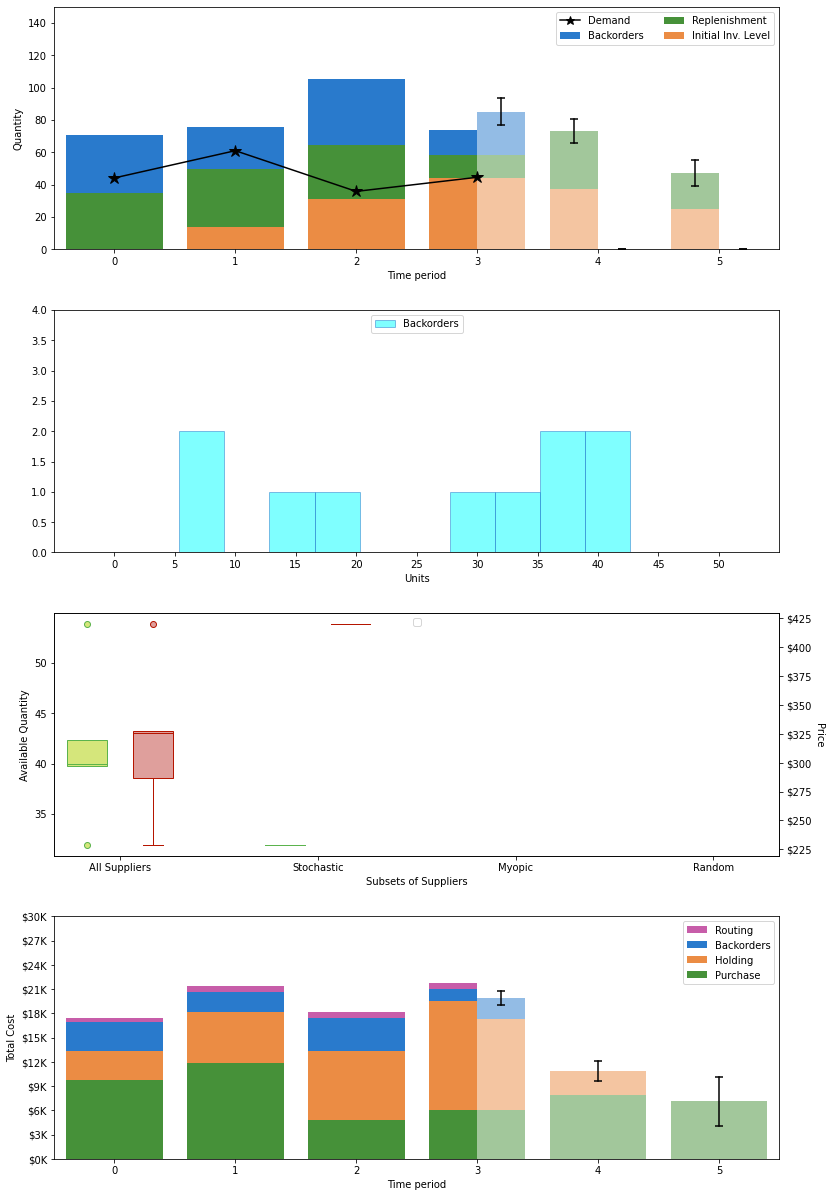

In [13]:
max_vals = charts_max_axis_values(0, states, real_actions, backorders, la_decisions, tws, iterables, costs, perished)
myopic_actions = [0]
visualize_by_day(0, 3, states, real_actions, backorders, la_decisions, realized_dem, q_sample, tws, iterables, costs, 0.9, max_vals, myopic_actions, perished)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\juan_\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\juan_\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\juan_\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\juan_\AppData\Local\Programs\Python\Python310\lib\site-packages\scip

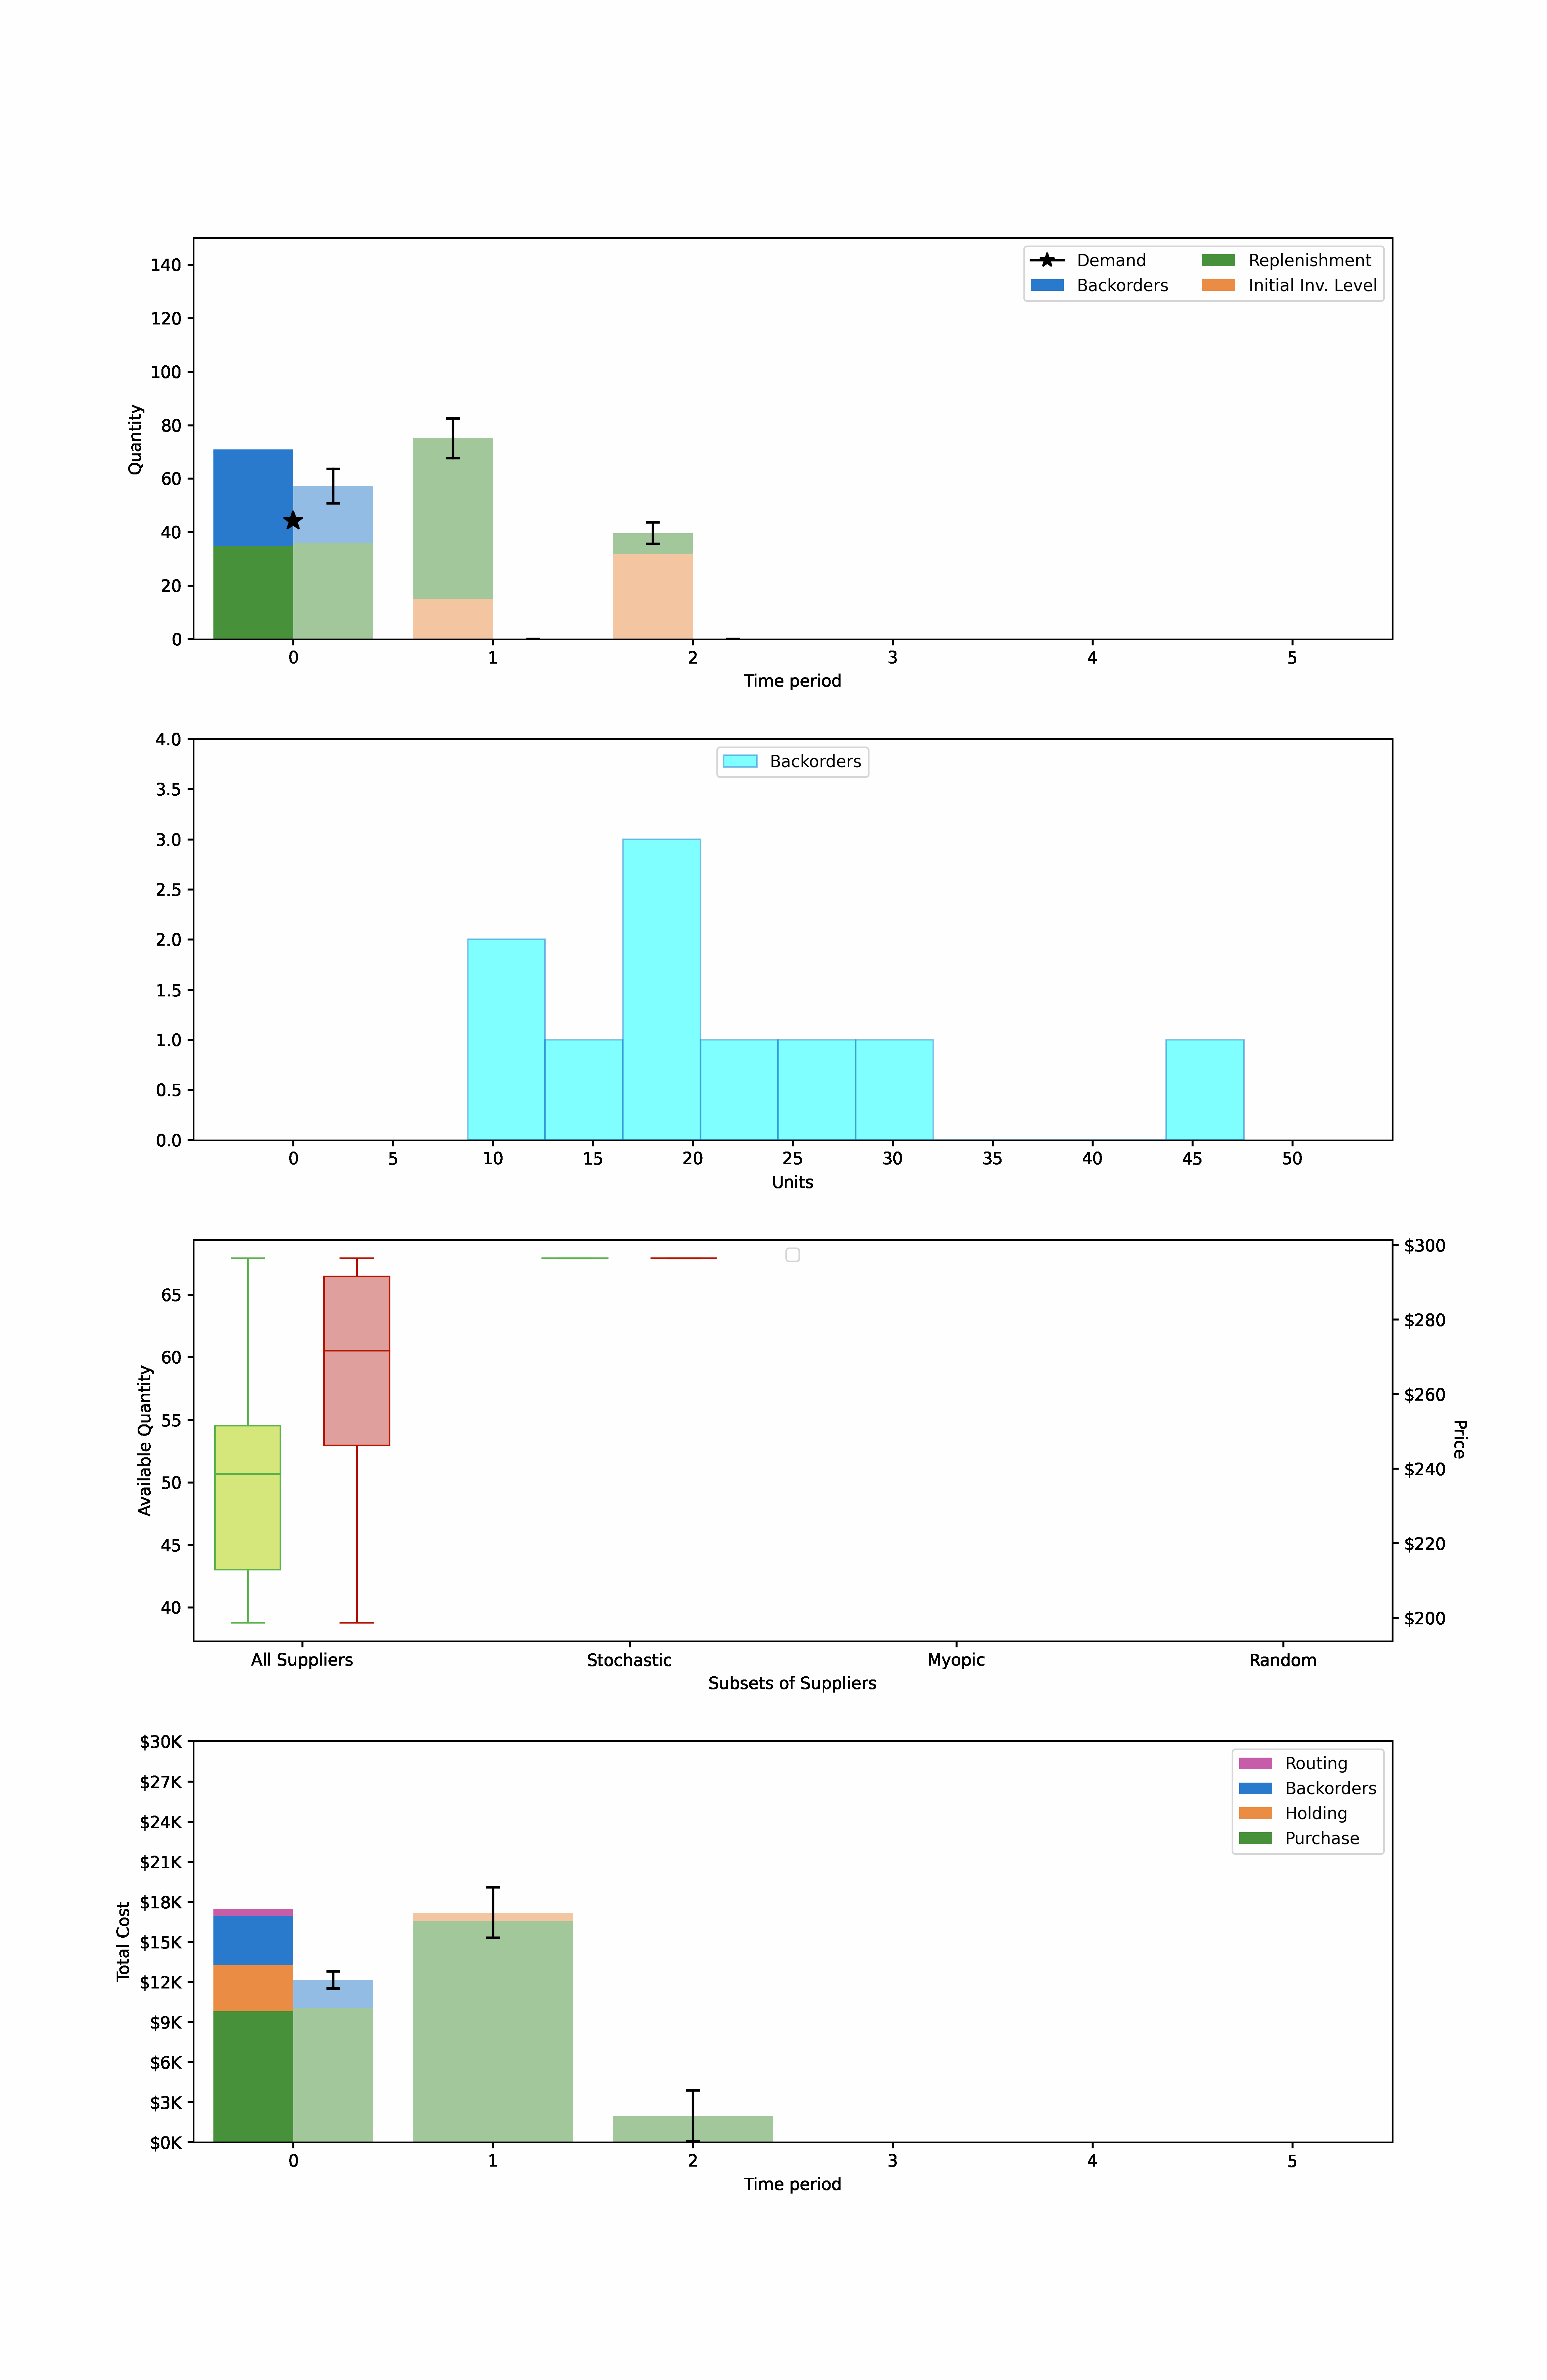

In [10]:
def display_policy_gif():
    
    for t in range(env_config["T"]):
        visualize_by_day(0, t, states, real_actions, backorders, la_decisions, realized_dem, q_sample, tws, iterables, costs, 0.9, max_vals, myopic_actions, perished, True)

    images = [imageio.imread(f"./RH shots/Rolling_{day}.png") for day in range(env_config["T"])]
    imageio.mimsave("./RH shots/RH.gif", images,duration=1)
    
    return Image(open("./RH shots/RH.gif",'rb').read(),width=600)
    
display_policy_gif()

In [9]:
print(realized_q[0,3])
print(q_sample[0,4][0])

{(1, 0): 19.52, (1, 1): 19.81, (1, 2): 9.77, (1, 3): 0, (1, 4): 19.51, (2, 0): 0, (2, 1): 18.25, (2, 2): 12.22, (2, 3): 0, (2, 4): 0, (3, 0): 13.16, (3, 1): 17.75, (3, 2): 0, (3, 3): 11.16, (3, 4): 16.7, (4, 0): 0, (4, 1): 0, (4, 2): 0, (4, 3): 16.53, (4, 4): 14.06, (5, 0): 0, (5, 1): 14.51, (5, 2): 0, (5, 3): 0, (5, 4): 0}
{(1, 0): 9.2, (1, 1): 16.38, (1, 2): 15.03, (1, 3): 0, (1, 4): 16.13, (2, 0): 0, (2, 1): 7.8, (2, 2): 18.14, (2, 3): 0, (2, 4): 0, (3, 0): 6.56, (3, 1): 14.76, (3, 2): 0, (3, 3): 7.76, (3, 4): 10.18, (4, 0): 0, (4, 1): 0, (4, 2): 0, (4, 3): 8.11, (4, 4): 6.78, (5, 0): 0, (5, 1): 11.87, (5, 2): 0, (5, 3): 0, (5, 4): 0}
